<a href="https://colab.research.google.com/github/nortonvanz/ML_Pocket_Reference/blob/main/notebooks/Titanic_pipeline_c3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resolução do Titanic utilizando CRISP-DM, seguindo o livro Machine Learning: Guia de Referência Rápica.

# Faça uma pergunta

Crie um modelo preditivo, que classifique se um indivíduo sobreviveu à catástrofe do Titanic (sim / não).

In [ ]:
#Dataset e problema original no Kaggle: https://www.kaggle.com/competitions/titanic

## Ciclo 3

In [ ]:
#objetivo: melhorar a métrica acurácia obtida, ao subteter no Kaggle as predições do Ttitanic do ciclo 2: Kaggle score: 0.68

In [ ]:
# estratégia:

  #inspecionar dados com SV, cruzando features com a target
  #implementar modelo linear
  #avançar com RandomForestClassifier
  #realizar experimentos nos dados, e
  #implementar o pipeline apenas no final.


### Imports

In [ ]:
#!pip install sweetviz
import sweetviz              as sv
#Análise de Colunas Colineares
#!pip install rfpimp
#import rfpimp

In [34]:
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns

# from collections             import Counter

# from yellowbrick.features    import RFECV

from sklearn.dummy             import DummyClassifier
# from sklearn.pipeline        import Pipeline
from sklearn.model_selection   import train_test_split, KFold, cross_val_score  #RandomizedSearchCV, GridSearchCV
from sklearn.impute            import SimpleImputer
from sklearn.preprocessing     import MinMaxScaler #OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler,
# from sklearn.compose         import ColumnTransformer
from sklearn.metrics           import confusion_matrix #make_scorer, f1_score, precision_score, recall_score, accuracy_score,  # balanced_accuracy_score,  , precision_recall_curve
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors         import KNeighborsClassifier

# from xgboost                 import XGBClassifier

### Aux Functions:

In [2]:
def standardize_cols(df):
  #converter tudo para minúsculo e com underline no lugar de espaços e pontos
  df.columns = df.columns.str.replace(' ','_').str.replace('.','_', regex=False).str.lower()
  return df

### Load Train Data

In [5]:
#load train data
!wget --quiet --show-progress https://raw.githubusercontent.com/nortonvanz/ML_Pocket_Reference/main/datasets/train.csv
df_raw_train = pd.read_csv('train.csv')
#padronizar nomes das colunas
df_raw_train = standardize_cols(df_raw_train)

train.csv           100%[===================>]  59.76K  --.-KB/s    in 0.01s   


### Split Datasets

In [6]:
# Separação das variáveis independentes e dependente
X = df_raw_train.drop(['survived'], axis=1)
y = df_raw_train['survived'].copy()

# Separação entre treino(75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42, stratify=y)

In [7]:
#mais linhas no treino, e menos no teste
X_train.shape, X_test.shape

((757, 11), (134, 11))

### Data Description

In [8]:
X_train.head(3)

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
400,401,3,"Niskanen, Mr. Juha",male,39.0,0,0,STON/O 2. 3101289,7.9250,NaN,S
122,123,2,"Nasser, Mr. Nicholas",male,32.5,1,0,237736,30.0708,NaN,C
358,359,3,"McGovern, Miss. Mary",female,NaN,0,0,330931,7.8792,NaN,Q


In [9]:
#dimensões
print(f'Linhas: {X_train.shape[0]}')
print(f'Colunas: {X_train.shape[1]}')

Linhas: 757
Colunas: 11


In [10]:
#tipos de dados
X_train.dtypes

passengerid      int64
pclass           int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
dtype: object

In [11]:
#check nulos
X_train.isna().sum()

passengerid      0
pclass           0
name             0
sex              0
age            148
sibsp            0
parch            0
ticket           0
fare             0
cabin          587
embarked         2
dtype: int64

### Preliminary analysis

In [12]:
#descrição das numéricas
X_train.describe()

,passengerid,pclass,age,sibsp,parch,fare
count,757.000000,757.000000,609.000000,757.000000,757.000000,757.000000
mean,444.726552,2.305152,29.761363,0.505945,0.384412,31.612147
std,257.521999,0.834531,14.584026,1.074736,0.825468,47.045655
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.000000,2.000000,20.500000,0.000000,0.000000,7.925000
50%,440.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,666.000000,3.000000,39.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### SV Report


In [ ]:
#Usar o Sweetviz para uma inspeção preliminar

# usa na EDA pro SV, para passar o target:
df_sv = pd.concat([X_train, y_train], axis=1)

# Generate report
report = sv.analyze(df_sv, target_feat='survived')

# Save and show on browser
report.show_html(filepath='sweetviz_report.html',open_browser=True)
#Report ../reports/sweetviz_report.html was generated.


                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
#Obervações a partir do report gerado:

In [ ]:
#Classes são desbalanceadas: 0=466 / 62%     1=291 / 38%

#Class 1: aprox. 2/3 sobreviveram, classe 3: aprox. 1/4 sobreviveu.

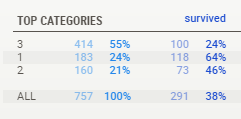

In [ ]:
#passengerid e name são únicos, e podem ser descartados

#sex: 18% dos homens sobreviveram, enquanto 75 das mulheres. É a var preditora de sobrevivência mais forte! (.24 de corr)

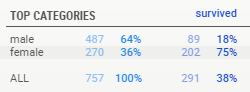

In [ ]:
#age, sibsp, parch: não evidenciam relação clara com survived

#ticket: sem um padrão claro, alguns com letra, outros números, outros ambos, pode ser descartado inicialmente

#fare: fares maiores, apresentam maior taxa de sobrevivência. Visualizar melhor distribuição

#cabin: 78% missing, desconsiderar

#embarked: sobrevivera mais embarked=C, depois Q, depois S. É informativa.

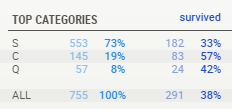

### Data Preparation

In [13]:
# inspect variations of each column
print(f"- Distinct values:\n{X_train.apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variations:\n{X_train.apply( lambda x: x.unique() ) } " )

- Distinct values:
passengerid    757
pclass           3
name           757
sex              2
age             86
sibsp            7
parch            7
ticket         598
fare           232
cabin          134
embarked         4
dtype: int64 

- Variations:
passengerid    [401, 123, 359, 627, 875, 708, 263, 518, 622, ...
pclass                                                 [3, 2, 1]
name           [Niskanen, Mr. Juha, Nasser, Mr. Nicholas, McG...
sex                                               [male, female]
age            [39.0, 32.5, nan, 57.0, 28.0, 42.0, 52.0, 11.0...
sibsp                                      [0, 1, 5, 3, 2, 4, 8]
parch                                      [0, 1, 2, 5, 4, 3, 6]
ticket         [STON/O 2. 3101289, 237736, 330931, 219533, P/...
fare           [7.925, 30.0708, 7.8792, 12.35, 24.0, 26.2875,...
cabin          [nan, E24, E67, D19, B69, E17, E121, D17, B94,...
embarked                                          [S, C, Q, nan]
dtype: object 


#### Remove columns

In [14]:
# dropar, assumindo não serem relevantes: passengerid, name, cabin (cabin tem quase metade das linhas com nulos), e ticket (números e letras, inúmeros códigos)
# age, sibsp, parch também foram removidas, visto que tem menor contribuição, e depois pode ser reavaliado.

X_train = X_train.drop(columns=['passengerid','name', 'cabin', 'ticket', 'age', 'sibsp', 'parch'])
X_test = X_test.drop(columns=['passengerid','name', 'cabin', 'ticket', 'age', 'sibsp', 'parch'])

In [15]:
X_train.head(3)

,pclass,sex,fare,embarked
400,3,male,7.9250,S
122,2,male,30.0708,C
358,3,female,7.8792,Q


#### Missing Data

In [16]:
X_train.isna().sum()

pclass      0
sex         0
fare        0
embarked    2
dtype: int64

In [17]:
#imputar o valor mais frequente em embarked
imputer = SimpleImputer(missing_values = np.nan, strategy ='most_frequent') # média   #strategy='median' ou 'most_frequent'
X_train.embarked = imputer.fit_transform(X_train["embarked"].values.reshape(-1, 1))

#conferir:
X_train.isna().sum()

pclass      0
sex         0
fare        0
embarked    0
dtype: int64

#### Tipos de dados

In [18]:
X_train.dtypes

pclass        int64
sex          object
fare        float64
embarked     object
dtype: object

#### Encodings

In [19]:
#Encodar as 2 features categóricas que não possuem hierarquia, criando novas colunas:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [20]:
X_train.head(3)

,pclass,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
400,3,7.9250,0,1,0,0,1
122,2,30.0708,0,1,1,0,0
358,3,7.8792,1,0,0,1,0


#### Scalers

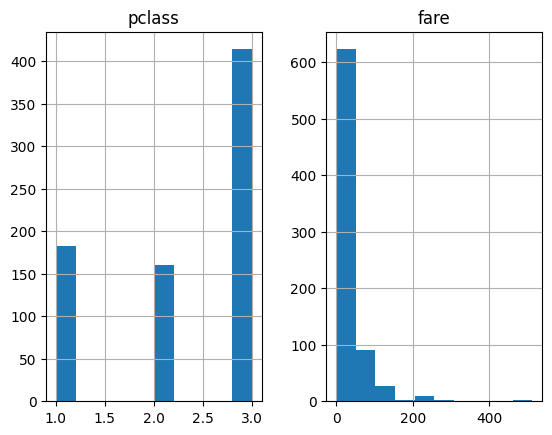

In [21]:
#Não é necessário encodar pclass, nem fare. Apenas serão reescaladas.
#visualizar o melhor scaler:
X_train[["pclass","fare"]].hist();

In [22]:
#não há outliers visíveis, visto que os valores são factíveis.
#como as distribuições não são normais, utilizar min-max-scaler

#pclass
mms_pclass = MinMaxScaler()
X_train.pclass = mms_pclass.fit_transform(X_train.pclass.values.reshape(-1, 1) )
X_test.pclass = mms_pclass.fit_transform(X_test.pclass.values.reshape(-1, 1) )

#fare
mms_fare = MinMaxScaler()
X_train.fare = mms_fare.fit_transform(X_train.fare.values.reshape(-1, 1) )
X_test.fare  = mms_fare.fit_transform(X_test.fare.values.reshape(-1, 1) )

In [23]:
X_train.head(3)

,pclass,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
400,1.0,0.015469,0,1,0,0,1
122,0.5,0.058694,0,1,1,0,0
358,1.0,0.015379,1,0,0,1,0


In [24]:
X_test.head(5)

,pclass,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
799,1.0,0.047138,1,0,0,0,1
553,1.0,0.014102,0,1,1,0,0
541,1.0,0.061045,1,0,0,0,1
441,1.0,0.018543,0,1,0,0,1
685,0.5,0.081157,0,1,1,0,0


### Machine Learning

#### Dummy Classifier (base model)

In [25]:
#o DummyClassifier serve como um modelo realmente simples, para dar uma ideia de como está nossos outros modelos:
  #por defaul, usa como stratrgy: “prior”: the predict method always returns the most frequent class label in the observed y argument passed to fit.

In [26]:
y_train.value_counts()
#vai prever sempre 0 (survived = Não)

0    466
1    291
Name: survived, dtype: int64

In [61]:
#instanciar
bm = DummyClassifier()
#fitar com treino
bm.fit(X_train, y_train)

#aplica cross validation, e avalia a performance com acurácia:
n_folds = 10
kf = KFold(n_splits=n_folds)
bm_score = cross_val_score(bm, X_test, y_test, scoring="accuracy", cv=kf)

# Exibir os resultados
print("Acurácia média:", bm_score.mean())

Acurácia média: 0.6214285714285716


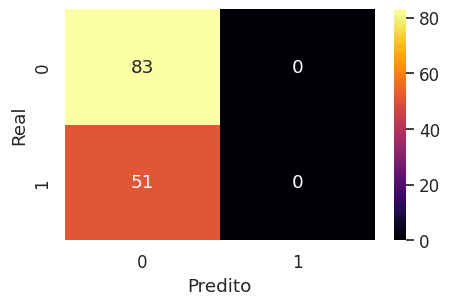

In [62]:
#prever contra teste
y_hat_bm = bm.predict(X_test)

# Matriz de Confusão
cnf_matrix = confusion_matrix(y_test, y_hat_bm) #y_true, y_pred
df_cm = pd.DataFrame(cnf_matrix, columns=np.unique(y_test), index=np.unique(y_test))
df_cm.index.name = 'Real'
df_cm.columns.name = 'Predito'
plt.figure(figsize = (5, 3))
sns.set(font_scale=1.1)
sns.heatmap(df_cm, cbar=True, cmap = 'inferno', annot = True, fmt='.0f');

In [29]:
#DummyClassifier: Chutando sempre a classe majoritária survived=0, o modelo teve uma acurácia média de: 0.62

#### KNN - baseline

In [63]:
#define
knn = KNeighborsClassifier(n_neighbors=4)
#fit
knn.fit(X_train, y_train)

#aplica cross validation, e avalia a performance com acurácia:
n_folds = 10
kf = KFold(n_splits=n_folds)
knn_score = cross_val_score(knn, X_test, y_test, scoring="accuracy", cv=kf)

# Exibir os resultados
print("Acurácia média:", knn_score.mean())

Acurácia média: 0.717032967032967


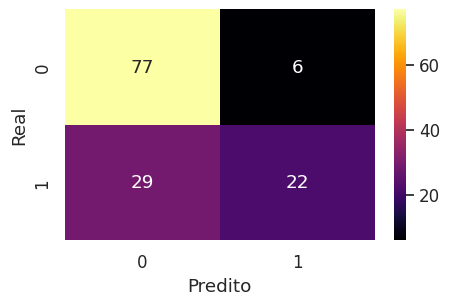

In [31]:
#predict
yhat_knn = knn.predict(X_test)

# Matriz de Confusão
cnf_matrix_knn = confusion_matrix(y_test, yhat_knn) #y_true, y_pred
df_cm_knn = pd.DataFrame(cnf_matrix_knn, columns=np.unique(y_test), index=np.unique(y_test))
df_cm_knn.index.name = 'Real'
df_cm_knn.columns.name = 'Predito'
plt.figure(figsize = (5, 3))
sns.set(font_scale=1.1)
sns.heatmap(df_cm_knn, cbar=True, cmap = 'inferno', annot = True, fmt='.0f');

In [32]:
#Knn: mesmo sem balanceamento de classes, o modelo teve uma acurácia média de: 0.71

#### RandomForestClassifier

In [35]:
#instanciar RFClassifier, com parâmetros mínimos
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=2)
#fitar
rf.fit(X_train, y_train)

#aplica cross validation, e avalia a performance com acurácia:
n_folds = 10
kf = KFold(n_splits=n_folds)
rf_score = cross_val_score(rf, X_test, y_test, scoring="accuracy", cv=kf)

# Exibir os resultados
print("Acurácia média:", rf_score.mean())

Acurácia média: 0.7384615384615385


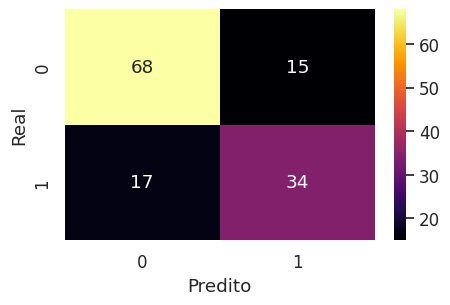

In [36]:
#predict
yhat_rf = rf.predict(X_test)

# Matriz de Confusão
cnf_matrix_rf = confusion_matrix(y_test, yhat_rf) #y_true, y_pred
df_cm_rf = pd.DataFrame(cnf_matrix_rf, columns=np.unique(y_test), index=np.unique(y_test))
df_cm_rf.index.name = 'Real'
df_cm_rf.columns.name = 'Predito'
plt.figure(figsize = (5, 3))
sns.set(font_scale=1.1)
sns.heatmap(df_cm_rf, cbar=True, cmap = 'inferno', annot = True, fmt='.0f');

In [37]:
#Visivelmente, a RF acerta mais do que erra ambas as classes, devido ao balanceamento, já possuindo uma acurácia de 0.73.

In [ ]:
#precisaria agora carregar df_raw_test, e fazer as transformações no dataset no braço, por não ter usado o pipeline.
#validar então se em dados inéditos, a performance se mantém
#ai, retreinaria o modelo final com estes dados também
#pular esta parte por hora, e submeter ao kaggle, para avaliar se já houve melhorias com o realizado neste ciclo:

### Load Kaggle Test

In [77]:
#carregar dataset de teste
!wget --quiet --show-progress https://raw.githubusercontent.com/nortonvanz/ML_Pocket_Reference/main/datasets/test.csv
df_raw_test = pd.read_csv('test.csv')
df_sub = df_raw_test.copy()

#padronizar nomes das colunas
df_raw_test = standardize_cols(df_raw_test)

test.csv.3          100%[===================>]  27.96K  --.-KB/s    in 0.002s  


In [78]:
#aplicar mesmas transformações que as realizadas no train.csv
df_raw_test.head(3)

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [79]:
#remover features
df_raw_test = df_raw_test.drop(columns=['passengerid','name', 'cabin', 'ticket', 'age', 'sibsp', 'parch'])

In [81]:
df_raw_test.head(3)

,pclass,sex,fare,embarked
0,3,male,7.8292,Q
1,3,female,7.0000,S
2,2,male,9.6875,Q


In [82]:
#conferir missings:
df_raw_test.isna().sum()

pclass      0
sex         0
fare        1
embarked    0
dtype: int64

In [83]:
#imputar o valor mais frequente em embarked
imputer_fare = SimpleImputer(missing_values = np.nan, strategy ='median') # média   #strategy='median' ou 'most_frequent'
df_raw_test.fare = imputer_fare.fit_transform(df_raw_test["fare"].values.reshape(-1, 1))

In [84]:
#conferir missings:
df_raw_test.isna().sum()

pclass      0
sex         0
fare        0
embarked    0
dtype: int64

In [85]:
#Encodar as 2 features categóricas que não possuem hierarquia, criando novas colunas:
df_raw_test = pd.get_dummies(df_raw_test)

In [86]:
#chamando os transformers já utilizados:
#pclass
df_raw_test.pclass = mms_pclass.transform(df_raw_test.pclass.values.reshape(-1, 1))
#fare
df_raw_test.fare  = mms_fare.transform(df_raw_test.fare.values.reshape(-1, 1) )

In [87]:
#confertidos no mesmo formato de X_train, usado no treino dos modelos
df_raw_test.head(3)

,pclass,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1.0,0.015282,0,1,0,1,0
1,1.0,0.013663,1,0,0,0,1
2,0.5,0.018909,0,1,0,1,0


In [88]:
X_train.head(3)

,pclass,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
400,1.0,0.015469,0,1,0,0,1
122,0.5,0.058694,0,1,1,0,0
358,1.0,0.015379,1,0,0,1,0


In [91]:
#usar o modelo final (RF) para prever:
#predict
yhat_rf_testkaggle= rf.predict(df_raw_test)
yhat_rf_testkaggle.shape

(418,)

### Kaggle Submission

In [94]:
#gerar df para submission no formato necessário
df_sub[:3]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [95]:
# padroniza no formato esperado pelo Kaggle
df_sub = df_sub[['PassengerId','Parch']]
df_sub = df_sub.rename(columns={"Parch": "Survived"})

In [96]:
# atribui as previsões do modelo
df_sub['Survived'] = yhat_rf_testkaggle

In [97]:
df_sub.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [98]:
#salvar arquivo para submeter
df_sub.to_csv('ciclo3_titanic_sub.csv', index=False)